In [11]:
import pandas as pd
import numpy as np
import itertools
import mplfinance as mpf
import re
import math
from math import floor
import sys
import os

import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import FunctionTransformer

import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback


df1 = pd.read_csv('df_final_part_1_log_returns.csv')
df2 = pd.read_csv('df_final_part_2_log_returns.csv')
df_final = pd.concat([df1, df2]).reset_index(drop=True)
other_cols = ['day_of_week_5', 'open_es', 'high_es', 'low_es', 'close_es', 'open_nq', 'high_nq', 'low_nq', 'close_nq', 'month', 'day']
df_final = df_final.drop(columns=other_cols)
df_final = df_final.replace([-np.inf], -1)

In [12]:
# Custom transformer to apply log transformation
class LogTransformer:
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.log(X + 1)  # Add 1 to handle zero values

Epoch 1/50
90/90 [==============================] - 1s 7ms/step - loss: 1472.5165 - val_loss: 24.6437
Epoch 2/50
90/90 [==============================] - 1s 6ms/step - loss: 13.4137 - val_loss: 19.1790
Epoch 3/50
90/90 [==============================] - 0s 6ms/step - loss: 4.0293 - val_loss: 16.9754
Epoch 4/50
90/90 [==============================] - 1s 6ms/step - loss: 2.0420 - val_loss: 16.5402
Epoch 5/50
90/90 [==============================] - 0s 6ms/step - loss: 1.2957 - val_loss: 16.1952
Epoch 6/50
90/90 [==============================] - 0s 5ms/step - loss: 0.9084 - val_loss: 16.5584
Epoch 7/50
90/90 [==============================] - 0s 6ms/step - loss: 0.7091 - val_loss: 16.6134
Epoch 8/50
90/90 [==============================] - 1s 6ms/step - loss: 0.5830 - val_loss: 16.7589
Epoch 9/50
90/90 [==============================] - 0s 6ms/step - loss: 0.5079 - val_loss: 16.7583
Epoch 10/50
90/90 [==============================] - 0s 6ms/step - loss: 0.4535 - val_loss: 17.1200
Epoch

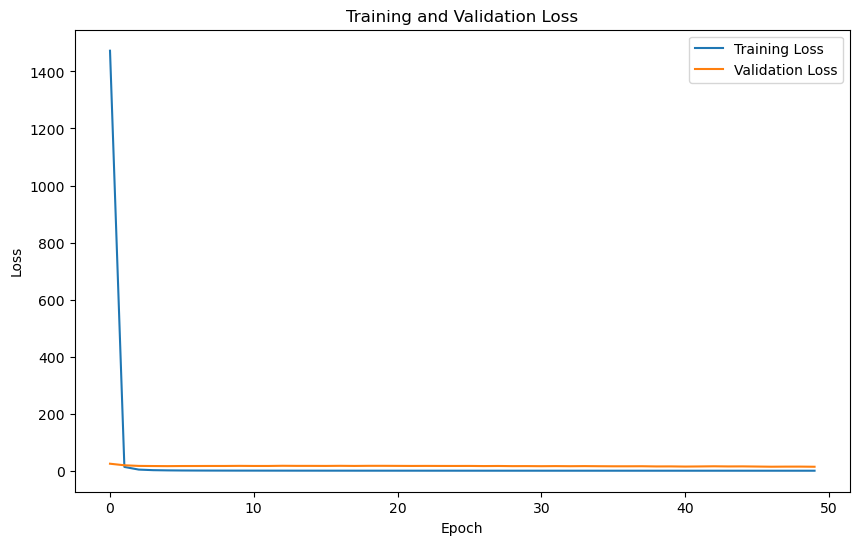

In [16]:
# Split data into features and target
target_cols = ['Morning_High', 'Morning_Low', 'Daily_High', 'Daily_Low']

X = df_final.drop(columns=target_cols)
y = df_final[target_cols]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Create a pipeline for preprocessing and modeling
price_cols = [
    col for col in X.columns 
    if any(sub in col for sub in ['open', 'high', 'low', 'close', 'swing_', '_low', '_high']) 
    and not any(sub in col for sub in ['next'])
]

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler()),
        #('num', FunctionTransformer(LogTransformer().transform), price_cols)
    ])

pipeline = Pipeline([
    #('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))  # Impute any missing values after log transformation
])

# Preprocess the data
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

# Define the MLP model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_preprocessed.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4)  # Two output neurons for 'Daily_High' and 'Daily_Low'
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Fit the model to the training data and use the custom callback
history = model.fit(X_train_preprocessed, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model on test data
y_pred = model.predict(X_test_preprocessed)

r2_scores = r2_score(y_test, y_pred, multioutput='raw_values')
mae_scores = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
mse_scores = mean_squared_error(y_test, y_pred, multioutput='raw_values')
rmse_scores = np.sqrt(mse_scores)

for i, (target, r2, mae, mse, rmse) in enumerate(zip(target_cols, r2_scores, mae_scores, mse_scores, rmse_scores)):
    print(f'{target} metrics:')
    print(f'R^2 score: {r2:.6f}')
    print(f'MAE: {mae:.6f}')
    print(f'MSE: {mse:.6f}')
    print(f'RMSE: {rmse:.6f}\n')
    
os.system("printf '\a'") # or '\7'

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [14]:
import pandas as pd

def get_most_accurate_predictions_combined_error(y_test, datetime_indexes, y_pred, target_names, N=10):
    # Calculate absolute errors for each target
    absolute_errors_target_1 = mean_absolute_error(y_test.iloc[:, 0], y_pred[:, 0])
    absolute_errors_target_2 = mean_absolute_error(y_test.iloc[:, 1], y_pred[:, 1])
    absolute_errors_target_3 = mean_absolute_error(y_test.iloc[:, 2], y_pred[:, 2])
    absolute_errors_target_4 = mean_absolute_error(y_test.iloc[:, 3], y_pred[:, 3])
    
    # Calculate combined absolute error
    combined_absolute_error_morning = -np.mean([absolute_errors_target_1, absolute_errors_target_2])
    combined_absolute_error_daily = -np.mean([absolute_errors_target_3, absolute_errors_target_4])

    # Create a DataFrame with datetime index, actual values, predicted values, and combined absolute error
    accuracy_df = pd.DataFrame({
        'datetime': datetime_indexes,
        'year': X_test.year,
        f'a_{target_names[0]}': y_test.iloc[:, 0],
        f'p_{target_names[0]}': y_pred[:, 0],
        f'a_{target_names[1]}': y_test.iloc[:, 1],
        f'p_{target_names[1]}': y_pred[:, 1],
        f'a_{target_names[2]}': y_test.iloc[:, 2],
        f'p_{target_names[2]}': y_pred[:, 2],
        f'a_{target_names[3]}': y_test.iloc[:, 3],
        f'p_{target_names[3]}': y_pred[:, 3],
        'combined_error_morning': combined_absolute_error_morning,
        'combined_error_daily': combined_absolute_error_daily
    })
    
    accuracy_df = accuracy_df.join(df_final[['month', 'day', 'open_es']])
    accuracy_df['a_Daily_High'] = round(np.exp(accuracy_df['a_Daily_High']) * accuracy_df.open_es,2)
    accuracy_df['a_Daily_Low'] = round(np.exp(accuracy_df['a_Daily_Low']) * accuracy_df.open_es,2)
    accuracy_df['p_Daily_High'] = round(np.exp(accuracy_df['p_Daily_High']) * accuracy_df.open_es,2)
    accuracy_df['p_Daily_Low'] = round(np.exp(accuracy_df['p_Daily_Low']) * accuracy_df.open_es,2)
    accuracy_df['a_Morning_High'] = round(np.exp(accuracy_df['a_Morning_High']) * accuracy_df.open_es,2)
    accuracy_df['a_Morning_Low'] = round(np.exp(accuracy_df['a_Morning_Low']) * accuracy_df.open_es,2)
    accuracy_df['p_Morning_High'] = round(np.exp(accuracy_df['p_Morning_High']) * accuracy_df.open_es,2)
    accuracy_df['p_Morning_Low'] = round(np.exp(accuracy_df['p_Morning_Low']) * accuracy_df.open_es,2)
    accuracy_df['combined_error_morning'] = combined_absolute_error_morning
    accuracy_df['combined_error_daily'] = combined_absolute_error_daily
    
    return accuracy_df

# Example usage
target_names = target_cols

# Get the most accurate predictions based on the combined error (assuming y_test and y_pred are defined)
most_accurate_df = get_most_accurate_predictions_combined_error(y_test, y_test.index, y_pred, target_names, N=10)

# Display the results
print("Most accurate predictions based on combined error:")
#most_accurate_df.head(10)
most_accurate_df.sort_values(by=['combined_error_morning', 'year', 'month', 'day'], ascending=False).head(10)

Most accurate predictions based on combined error:


,datetime,year,a_Morning_High,p_Morning_High,a_Morning_Low,p_Morning_Low,a_Daily_High,p_Daily_High,a_Daily_Low,p_Daily_Low,combined_error_morning,combined_error_daily,month,day,open_es
4500,4500,2023,4188.25,4174.59,4149.50,4156.79,4188.25,4176.18,4137.26,4156.56,-0.003413,-0.005288,4,14,4165.50
4499,4499,2023,4148.75,4139.27,4124.50,4121.61,4177.00,4140.84,4124.50,4121.38,-0.003413,-0.005288,4,13,4130.25
4498,4498,2023,4160.00,4166.07,4120.01,4148.31,4160.00,4167.66,4112.51,4148.08,-0.003413,-0.005288,4,12,4157.00
4497,4497,2023,4142.00,4150.79,4128.00,4133.09,4151.00,4152.37,4128.00,4132.86,-0.003413,-0.005288,4,11,4141.75
4496,4496,2023,4116.50,4113.71,4097.75,4096.17,4136.49,4115.28,4097.75,4095.94,-0.003413,-0.005288,4,10,4104.75
4495,4495,2023,4122.00,4116.97,4097.00,4099.41,4135.75,4118.54,4097.00,4099.18,-0.003413,-0.005288,4,6,4108.00
4494,4494,2023,4128.25,4129.49,4102.25,4111.88,4128.25,4131.07,4099.50,4111.65,-0.003413,-0.005288,4,5,4120.50
4493,4493,2023,4164.25,4170.08,4126.24,4152.30,4164.25,4171.67,4116.24,4152.07,-0.003413,-0.005288,4,4,4161.00
4492,4492,2023,4157.75,4141.52,4127.75,4123.86,4157.75,4143.10,4127.75,4123.63,-0.003413,-0.005288,4,3,4132.50
4491,4491,2023,4117.01,4100.18,4089.50,4082.69,4142.26,4101.74,4089.50,4082.47,-0.003413,-0.005288,3,31,4091.25
